# Instructions
You will submit an HTML document to Canvas as your final version.

Your document should show your code chunks/cells as well as any output. Make sure that only relevant output is printed. Do not, for example, print the entire dataset in your final rendered file.

Your document should also be clearly organized, so that it is easy for a reader to find your answers to each question.

# The Data
In this lab, we will use medical data to predict the likelihood of a person experiencing an exercise-induced heart attack.

Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain (“angina”) during exercise. The information collected includes:

- age : Age of the patient

- sex : Sex of the patient

- cp : Chest Pain type
    - Value 0: asymptomatic
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
- trtbps : resting blood pressure (in mm Hg)

- chol : cholesterol in mg/dl fetched via BMI sensor

- restecg : resting electrocardiographic results

    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes’ criteria
- thalach : maximum heart rate achieved during exercise

- output : the doctor’s diagnosis of whether the patient is at risk for a heart attack

    - 0 = not at risk of heart attack
    - 1 = at risk of heart attack
    
Although it is not a formal question on this assignment, you should begin by reading in the dataset and briefly exploring and summarizing the data, and by adjusting any variables that need cleaning.


In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from plotnine import ggplot, aes, geom_line, geom_abline, labs, theme_classic, ggtitle, scale_color_manual

ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
print(ha.head())

# Create target and predictor variables and split
X = ha.drop(columns=['output'])
y = ha['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)


   age  sex  cp  trtbps  chol  restecg  thalach  output
0   63    1   3     145   233        0      150       1
1   37    1   2     130   250        1      187       1
2   56    1   1     120   236        1      178       1
3   57    0   0     120   354        1      163       1
4   57    1   0     140   192        1      148       1


# Part One: Fitting Models
This section asks you to create a final best model for each of the model types studied this week. For each, you should:

- Find the best model based on ROC AUC for predicting the target variable.

- Report the (cross-validated!) ROC AUC metric.

- Fit the final model.

- Output a confusion matrix; that is, the counts of how many observations fell into each predicted class for each true class.

- (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You should include any hyperparameter tuning steps in your writeup as well.

- Q1: KNN
- Q2: Logistic Regression
- Q3: Decision Tree
- Q4: Interpretation
Which predictors were most important to predicting heart attack risk?

- Q5: ROC Curve
Plot the ROC Curve for your three models above.


In [10]:
# Q1
pipeline_KNN = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', KNeighborsClassifier())
])
# Create grid for tuning
knn_params = {'regressor__n_neighbors': range(1, 21)}
knn_grid = GridSearchCV(pipeline_KNN, knn_params, cv=5, scoring='roc_auc')
knn_grid.fit(X_train, y_train)

# Best KNN model
print(f"Best KNN parameters: {knn_grid.best_params_}")
print(f"\nBest ROC AUC: {knn_grid.best_score_}")

# Confusion matrix
y_pred_knn = knn_grid.best_estimator_.predict(X_test)
print("\nConfusion Matrix:\n",confusion_matrix(y_test, y_pred_knn))

Best KNN parameters: {'regressor__n_neighbors': 14}

Best ROC AUC: 0.8812257917521077

Confusion Matrix:
 [[19 13]
 [14 23]]


In [19]:
# Q2
pipeline_logistic = Pipeline([
    ('preprocessor', ct),
    ('regressor', LogisticRegression(max_iter=1000))
])

# Create grid for tuning
logreg_params = {'regressor__C': [0.01, 0.1, 1, 10, 100]}
logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='roc_auc')
logreg_grid.fit(X_train, y_train)

# Best Logistic Regression model
print(f"Best Logistic Regression parameters: {logreg_grid.best_params_}")
print(f"\nBest ROC AUC: {logreg_grid.best_score_}")

# Confusion matrix
y_pred_logreg = logreg_grid.best_estimator_.predict(X_test)
print("\nConfusion Matrix:\n",confusion_matrix(y_test, y_pred_logreg))

Best Logistic Regression parameters: {'regressor__C': 0.01}

Best ROC AUC: 0.8696286169970382

Confusion Matrix:
 [[16 16]
 [ 4 33]]


In [20]:
# Q3
pipeline_tree = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', DecisionTreeClassifier(random_state=42))
])

# Create grid for tuning
tree_params = {'regressor__max_depth': range(1, 11), 'regressor__min_samples_split': range(2, 10)}
tree_grid = GridSearchCV(pipeline_tree, tree_params, cv=5, scoring='roc_auc')
tree_grid.fit(X_train, y_train)

# Best Decision Tree model
print(f"Best Decision Tree parameters: {tree_grid.best_params_}")
print(f"\nBest ROC AUC: {tree_grid.best_score_}")

# Confusion matrix
y_pred_tree = tree_grid.best_estimator_.predict(X_test)
print("\nConfusion Matrix:\n",confusion_matrix(y_test, y_pred_tree))

Best Decision Tree parameters: {'regressor__max_depth': 4, 'regressor__min_samples_split': 9}

Best ROC AUC: 0.7980633401686035

Confusion Matrix:
 [[23  9]
 [14 23]]


In [26]:
# # Q4
# Logistic Regression coefficients
logreg_coef = logreg_grid.best_estimator_.named_steps['regressor'].coef_
features = X.columns
print("Logistic Regression Coefficients:")
for feature, coef in zip(features, logreg_coef[0]):
    print(f"{feature}: {coef}")

# Decision Tree feature importance
# Access the DecisionTreeClassifier inside the pipeline
tree_model = tree_grid.best_estimator_.named_steps['regressor']

# Extract feature importance
tree_importance = tree_model.feature_importances_

# Print feature importance
print("\nDecision Tree Coefficients:")
for feature, importance in zip(features, tree_importance):
    print(f"{feature}: {importance}")



Logistic Regression Coefficients:
age: -0.12684753225515646
sex: -0.22244160460441015
cp: 0.23988396753322755
trtbps: -0.058956395174713225
chol: -0.018741364114553006
restecg: 0.10264697110656161
thalach: 0.27124808028963976

Decision Tree Coefficients:
age: 0.10546644762158729
sex: 0.11907759551841351
cp: 0.4668747221205135
trtbps: 0.07660834827959367
chol: 0.020639223083664247
restecg: 0.0
thalach: 0.21133366337622775


By looking at the absolute values of the coefficients we can see that in both logistic regression and decision tree regression we get that one of the most important predictors is **cp**, chest pain type.  We also see that **thelach**, maximum heart rate achieved when exercising, is another important predictor for heart attacks. These two predictors make sense in the context of the problem in that they directly correlate to the hearts functionality. Some other interesting information that comes from the coefficients is how in the decision tree regression all of the predictor variables have a positive impact, where in the logistic regression, almost half of the coefficients are negative. Then, from our analysis of ROC AUC, we see that the negative predictors contributed to a better score. This tells us that the negative coefficients for **age**, **sex**, **trtbps**, and **chol** help to predict heart attacks better

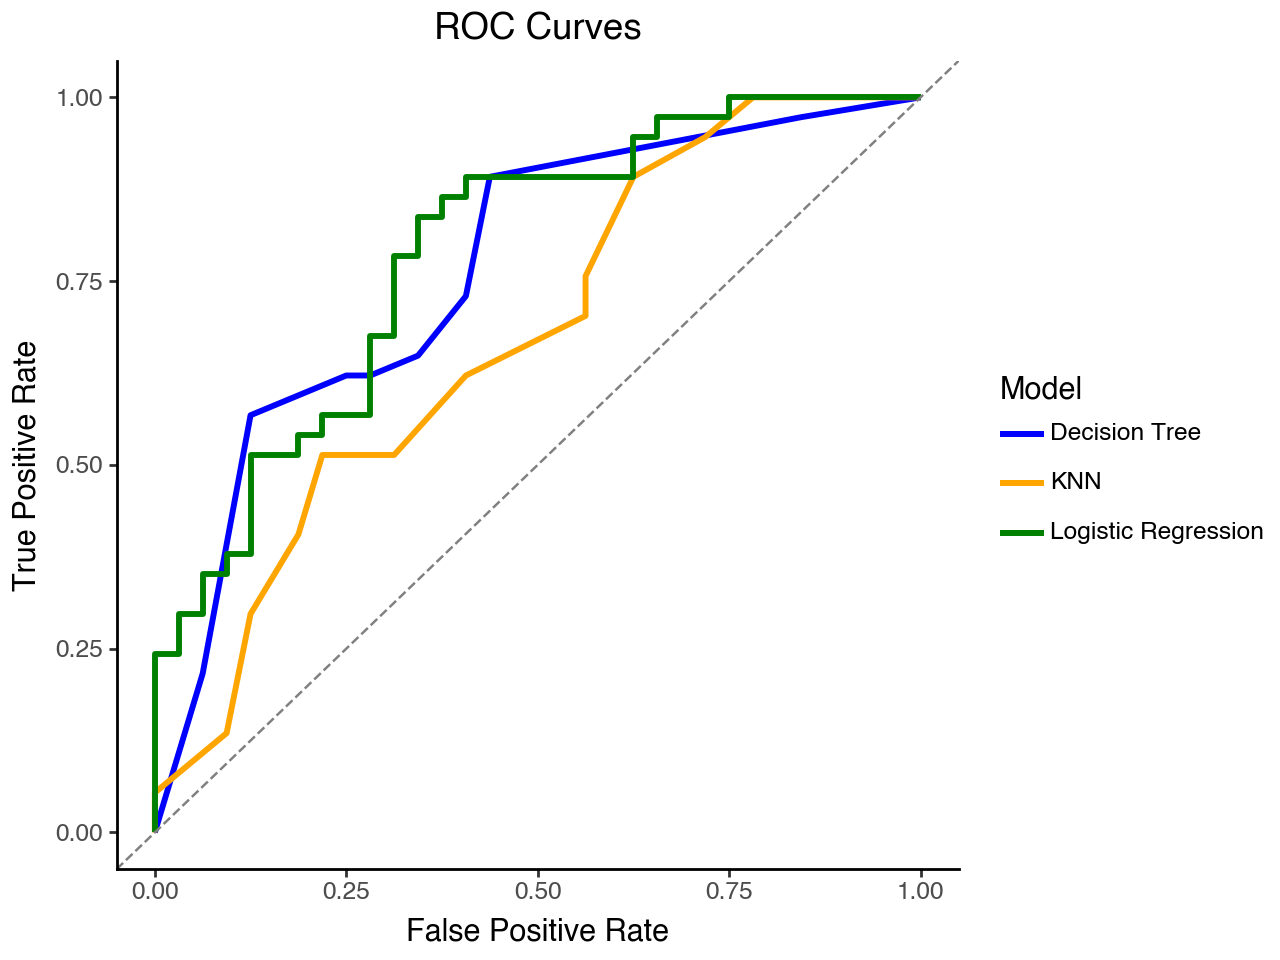

In [30]:
# Q5
# Compute ROC Curves
roc_data = []
for model, name in zip([knn_grid, logreg_grid, tree_grid], ['KNN', 'Logistic Regression', 'Decision Tree']):
    y_probs = model.best_estimator_.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_data.append(pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'model': name}))

roc_df = pd.concat(roc_data)

# Plot ROC Curves using ggplot
roc_plot = (
    ggplot(roc_df, aes(x='fpr', y='tpr', color='model')) +
    geom_line(size=1.2) +
    geom_abline(linetype='dashed', color='gray') +
    labs(
        title='ROC Curve Comparison',
        x='False Positive Rate',
        y='True Positive Rate',
        color='Model'
    ) +
    theme_classic() +
    ggtitle("ROC Curves") +
    scale_color_manual(values=['blue', 'orange', 'green'])
)
roc_plot.show()



# Part Two: Metrics
Consider the following metrics:

- True Positive Rate or Recall or Sensitivity = Of the observations that are truly Class A, how many were predicted to be Class A?

- Precision or Positive Predictive Value = Of all the observations classified as Class A, how many of them were truly from Class A?

- True Negative Rate or Specificity or Negative Predictive Value = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.


In [43]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def compute_metrics(model, X, y, class_label):
    # Cross-validated predictions
    y_pred = cross_val_predict(model, X, y, cv=5)
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Metrics
    Sensitivity = tp / (tp + fn)  # True Positive Rate
    precision = tp / (tp + fp)  # Positive Predictive Value
    specificity = tn / (tn + fp)  # True Negative Rate
    
    return {
        "Sensitivity": Sensitivity,
        "Precision": precision,
        "Specificity": specificity
    }

# Metrics for KNN
knn_model = knn_grid.best_estimator_
knn_metrics = compute_metrics(knn_model, X, y, class_label=1)

# Metrics for Logistic Regression
logreg_model = logreg_grid.best_estimator_
logreg_metrics = compute_metrics(logreg_model, X, y, class_label=1)

# Metrics for Decision Tree
tree_model = tree_grid.best_estimator_
tree_metrics = compute_metrics(tree_model, X, y, class_label=1)

def format_metrics(metrics, model_name):
    print(f" {model_name} Metrics:")
    print(f"- Sensitivity: {metrics['Sensitivity'] * 100:.2f}%")
    print(f"- Precision: {metrics['Precision'] * 100:.2f}%")
    print(f"- Specificity: {metrics['Specificity'] * 100:.2f}%\n")

# Display formatted metrics
format_metrics(knn_metrics, "KNN")
format_metrics(logreg_metrics, "Logistic Regression")
format_metrics(tree_metrics, "Decision Tree")



 KNN Metrics:
- Sensitivity: 78.77%
- Precision: 76.67%
- Specificity: 72.44%

 Logistic Regression Metrics:
- Sensitivity: 86.99%
- Precision: 74.27%
- Specificity: 65.35%

 Decision Tree Metrics:
- Sensitivity: 73.29%
- Precision: 74.31%
- Specificity: 70.87%




# Part Three: Discussion
Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

- Which metric(s) you would use for model selection and why.

- Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

- What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

### Q1: The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

In this situation, Sensitivity (Recall) is the most important metric, as it ensures that we identify as many high-risk patients as possible, minimizing the chance of missing a true case of heart attack risk. The Logistic Regression model is the best choice since it has the highest Sensitivity at 86.99%, making it the most reliable for detecting high-risk patients. We can expect the Logistic Regression model to achieve a Sensitivity of 86.99%, Precision of 74.27%, and Specificity of 65.35% based on cross-validation results.

### Q2: The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

Here, Precision is critical because it ensures that the patients identified as high-risk truly need monitoring, minimizing false positives and conserving hospital resources. The Decision Tree model is recommended since it has the highest Precision at 74.31%, ensuring efficient allocation of beds to the most critical patients. The Decision Tree model is expected to achieve a Precision of 74.31%, Sensitivity of 73.29%, and Specificity of 70.87% based on cross-validation results.

### Q3: The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

Interpretability is the main priority here, as the hospital needs to understand which predictors are most strongly associated with heart attack risk. Accuracy metrics are secondary in this context.The Logistic Regression model is ideal because its coefficients provide clear insights into the direction and strength of the relationship between predictors and heart attack risk. Alternatively, the Decision Tree model offers a visual representation of these relationships. For Logistic Regression, we expect a Sensitivity of 86.99%, Precision of 74.27%, and Specificity of 65.35%. For the Decision Tree, we expect a Sensitivity of 73.29%, Precision of 74.31%, and Specificity of 70.87%.

### Q4: The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

Cohen’s Kappa is the best metric for this scenario because it measures the agreement between the model and the doctors’ diagnoses, accounting for any agreement that happens by chance. The KNN model is the most appropriate for this situation. While Logistic Regression has slightly better Sensitivity, KNN has a good balance of Sensitivity (78.77%) and Precision (76.67%) alongside a Specificity of 72.44%. KNN’s proximity-based predictions can be used effectively to compare with doctors' decisions, as they align well with case-by-case reasoning that new doctors may employ. For KNN, we expect a Sensitivity of 78.77%, Precision of 76.67%, and Specificity of 72.44%. Cohen’s Kappa for KNN should also show strong alignment with the doctors' diagnoses.



# Part Four: Validation
Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.


In [47]:

ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
X_val = ha_validation.drop(columns=['output'])
y_val = ha_validation['output']

Use each of your final models in Part One Q1-3, predict the target variable in the validation dataset.

For each, output a confusion matrix, and report the ROC AUC, the precision, and the recall.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?


In [49]:
def evaluate_model(model, X_val, y_val, model_name):
    # Predictions
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]
    
    # Metrics
    roc_auc = roc_auc_score(y_val, y_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    
    # Print results
    print(f"{model_name}:")
    print(f"- ROC AUC: {roc_auc:.2f}")
    print(f"- Precision: {precision:.2f}")
    print(f"- Recall: {recall:.2f}")
    print("Confusion Matrix:")
    print(cm)
    print("\n")
    return roc_auc, precision, recall, cm

# Evaluate each model
knn_results = evaluate_model(knn_grid.best_estimator_, X_val, y_val, "KNN")
logreg_results = evaluate_model(logreg_grid.best_estimator_, X_val, y_val, "Logistic Regression")
tree_results = evaluate_model(tree_grid.best_estimator_, X_val, y_val, "Decision Tree")


KNN:
- ROC AUC: 0.91
- Precision: 0.85
- Recall: 0.58
Confusion Matrix:
[[ 9  2]
 [ 8 11]]


Logistic Regression:
- ROC AUC: 0.92
- Precision: 0.88
- Recall: 0.79
Confusion Matrix:
[[ 9  2]
 [ 4 15]]


Decision Tree:
- ROC AUC: 0.74
- Precision: 0.92
- Recall: 0.63
Confusion Matrix:
[[10  1]
 [ 7 12]]





# Part Five: Cohen’s Kappa
Another common metric used in classification is Cohen’s Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen’s Kappa instead? Does this make sense?

In [51]:
from sklearn.metrics import cohen_kappa_score

# Function to calculate Cohen's Kappa
def calculate_kappa(model, X_val, y_val, model_name):
    y_pred = model.predict(X_val)
    kappa = cohen_kappa_score(y_val, y_pred)
    print(f"{model_name} Cohen's Kappa: {kappa:.2f}")
    return kappa

# Calculate Kappa for each model
knn_kappa = calculate_kappa(knn_grid.best_estimator_, X_val, y_val, "KNN")
logreg_kappa = calculate_kappa(logreg_grid.best_estimator_, X_val, y_val, "Logistic Regression")
tree_kappa = calculate_kappa(tree_grid.best_estimator_, X_val, y_val, "Decision Tree")


KNN Cohen's Kappa: 0.36
Logistic Regression Cohen's Kappa: 0.59
Decision Tree Cohen's Kappa: 0.48


Cohen’s Kappa is a way to measure how well the model’s predictions match the actual outcomes while considering that some matches might happen by chance. In this case, Logistic Regression had the best Kappa score (0.59), which means it had the highest agreement with the actual data, followed by the Decision Tree (0.48) and KNN (0.36). This makes Logistic Regression the most reliable model overall, especially for situations like comparing predictions to doctor diagnoses. These results match up with what we saw earlier, so it makes sense to stick with logistic regression for important tasks like reducing mistakes or helping doctors make decisions. It makes sense that our logistic regression model would have the best Cohen's Kappa score because it provides a good balance between sensitivity and precision, the model’s ability to correctly classify both high-risk and low-risk patients, while accounting for chance, is vital.